# Exploration
This notebook will explore our dataset to inform our cleaning activities.

## Dictionary

- ID : the numeric ID of the article
- TITLE : the headline of the article
- URL : the URL of the article
- PUBLISHER : the publisher of the article
- CATEGORY : the category of the news item; one of:
  - e : entertainment
  - b : business
  - t : science and technology
  - m : health
- STORY : alphanumeric ID of the news story that the article discusses
- HOSTNAME : hostname where the article was posted
- TIMESTAMP : approximate timestamp of the article's publication, given in Unix time (seconds since midnight on Jan 1, 1970)

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re

from sklearn.feature_extraction.text import CountVectorizer

from src.model_operations import count_tokens

c:\Users\hlmq\code\macop_training_2025\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import data
data = pd.read_csv("data/downsampled_dataset.csv")

# Global Dataset Statistics

In [3]:
# What does the data look like?
data.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,295933,HBO's 'Game of Thrones' Finale Draws 7.1 Milli...,http://variety.com/2014/tv/ratings/hbos-game-o...,Variety,1,dC3-DM8Lb3vGU5Mkhf3DSUhxreGDM,variety.com,1403015867587
1,120908,Yahoo shares surge after first quarter revenue...,http://www.bizjournals.com/sanjose/news/2014/0...,Silicon Valley Business Journal,2,dT_6B-49u7PCtGMmH5Z4F4aMi-tKM,www.bizjournals.com,1397641368477
2,95402,UPDATE 2-Hotel chain La Quinta makes subdued d...,http://www.reuters.com/article/2014/04/09/laqu...,Reuters,2,d2cfi33G40EuaaMxFzMxeeXjzFgvM,www.reuters.com,1397065266477
3,234064,Major Study Finds E-Cigarettes Great for Quitt...,http://www.highlightpress.com/major-study-find...,Highlight Press,4,dUsqYpuEIbZlGfMjE1lyduks_WBVM,www.highlightpress.com,1400709444772
4,305499,The Most Important Features In Amazon's New Fi...,http://www.seattlepi.com/technology/businessin...,seattlepi.com,2,du-1bLu6hjI-CbM2f51YYbHc8JZGM,www.seattlepi.com,1403187295257


In [4]:
# How many observations?
len(data)

84484

In [5]:
# What is a typical article title?
data['TITLE'][100]

'LARRY PRATT: Meteor shower may be sight to see'

# Target Column Exploration

In [6]:
# Any missing values?
data['CATEGORY'].isnull().sum()

0

In [7]:
# Distribution of values
data['CATEGORY'].value_counts()

CATEGORY
3    30224
2    22666
4    16117
1    15477
Name: count, dtype: int64

# Text Column Exploration

In [8]:
# Any missing values?
data['TITLE'].isnull().sum()

0

## Length of TITLE (number of words)

This has a large impact on our choice of Large Language Model (LLM). 

LLMs operate on a fixed sequence length.  

This means any string shorter than N number of words will be padded to reach a max length.  

This max length is set when the LLM is trained.  

Further, this is one of the factors that makes different LLMs better at a task than others. 

In [9]:
# Check average length of TITLE values
data['title length'] = data['TITLE'].apply(count_tokens)


# Print out metrics
print(f"Minimum number of words in TITLE: {np.round(data['title length'].min())}")
print(f"Average number of words in TITLE: {np.round(data['title length'].mean())}")
print(f"Maximum number of words in TITLE: {np.round(data['title length'].max())}")

Minimum number of words in TITLE: 1
Average number of words in TITLE: 9.0
Maximum number of words in TITLE: 777


In [10]:
# Investigate Max values in TITLE
n = 10
high_values = data[data['title length']>n]

print(f"Number of TITLE obs with more than {n} words: {len(high_values)}")
high_values['TITLE'].iloc[0]

Number of TITLE obs with more than 10 words: 25726


'UPDATE 2-Hotel chain La Quinta makes subdued debut in crowded IPO market'

In [11]:
# Investigate Min and Max values in TITLE
n = 3
low_values = data[data['title length']<= n]

# Number of short titles
print(f"Number of TITLE obs with less than {n} words: {len(low_values)}")
# Check a single value 
low_values['TITLE'].iloc[0]

Number of TITLE obs with less than 3 words: 1022


'Holy Thursday'

## Check Special Characters

In [12]:
# How many observations have special characters?

def check_for_special_chars(data):
    """ Checks if a string is comprised entirely of alphanumeric characters. """
    return data.isalnum()

# Check to see if special characters are present
data['special chars present'] = data['TITLE'].apply(check_for_special_chars)
# Check number of observations with special characters
data['special chars present'].sum()

12

In [13]:
# Check how prevalent special chars are in the text
def remove_special_chars(data): 
    """ Removes special chars from a string. """
    return re.sub("[$&+;=@#|<>^*%-]","",data)

# Remove special characters
data['special chars removed'] = data['TITLE'].apply(check_for_special_chars)

## Check Word Frequency

In [14]:
# Most frequent 50 words

#Create DTM
cv = CountVectorizer(ngram_range = (1,1))
dtm = cv.fit_transform(data['TITLE'])
words = np.array(cv.get_feature_names_out())


#Look at top 50 most frequent words
freqs=dtm.sum(axis=0).A.flatten() 
index=np.argsort(freqs)[-20:] 
print(list(zip(words[index], freqs[index])))

WordFreq = pd.DataFrame.from_records(list(zip(words[index], freqs[index]))) 
WordFreq.columns = ['Word', 'Freq']

data = dict(zip(WordFreq['Word'].tolist(), WordFreq['Freq'].tolist()))

[('up', 2286), ('be', 2298), ('after', 2349), ('by', 2364), ('from', 2612), ('apple', 2772), ('as', 3243), ('google', 3376), ('us', 3776), ('is', 4180), ('at', 4188), ('new', 5059), ('with', 5106), ('and', 6864), ('on', 7729), ('for', 10937), ('of', 11131), ('the', 12383), ('in', 14262), ('to', 21022)]


Text(0.5, 1.0, 'Count of Most Common Words')

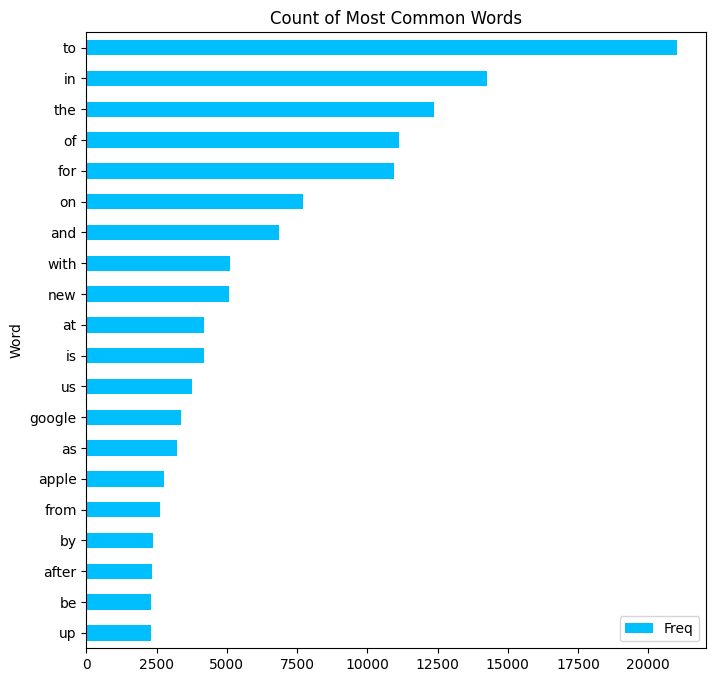

In [15]:
# Plot horizontal bar graph
fig, ax = plt.subplots(figsize=(8, 8))
WordFreq.sort_values(by='Freq').plot.barh(
                      x='Word',
                      y='Freq',
                      ax=ax,
                      color="deepskyblue")

plt.title("Count of Most Common Words")